# Task
https://github.com/netology-ds-team/nlp-homeworks/tree/main/3_Thematic_modeling

**Классификация по тональности**

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.

**Часть 1. Анализ текстов**

Посчитайте количество отзывов в разных городах и на разные банки

Постройте гистограмы длин **слов** в символах и в **словах**

Найдите 10 самых частых:

слов

слов без стоп-слов

лемм

существительных

Постройте кривые Ципфа и Хипса

Ответьте на следующие вопросы:

какое слово встречается чаще, "сотрудник" или "клиент"?

сколько раз встречается слова "мошенничество" и "доверие"?

В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. 
Используйте меру tf-idf, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

**Часть 2. Тематическое моделирование**

Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

**Часть 3. Классификация текстов**

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

Используйте любой известный вам алгоритм **векторизации** текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных -грам.

Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:

1-ый вариант:   tf-idf преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),

2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

# Load data

In [ ]:
import json
import bz2
from tqdm import tqdm

responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [03:59, 838.82it/s] 


In [ ]:
responses[23]

{'city': 'г. Волгодонск (Ростовская обл.)',
 'rating_not_checked': False,
 'title': 'Купи монетку на память',
 'num_comments': 2,
 'bank_license': 'лицензия № 1623',
 'author': 'visacom',
 'bank_name': 'ВТБ 24',
 'datetime': '2015-06-05 17:11:07',
 'text': 'В 2014 году \xa0в банке ВТБ 24 была приобретена серебряная монета 925 пробы знак зодиака Рыба. Возникла необходимость сдать монету в обмен на деньги. Обратилась в Банк ВТБ 24 - отказали в связи с тем, что банк только продаёт монеты, но не покупает их назад.\xa0Обратилась в Сбербанк - там даже в каталоге не нашли эту монету. Что дальше?!',
 'rating_grade': None}

In [ ]:
import pandas as pd

df = pd.DataFrame(responses)
del responses
df.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN


## Посчитайте количество отзывов в разных городах и на разные банки

In [ ]:
df.value_counts('city')

city
г. Москва                           55354
г. Санкт-Петербург                  14342
г. Екатеринбург                      2337
г. Новосибирск                       2300
г. Нижний Новгород                   1976
                                    ...  
г. Москва, Ногинск (Москва)             1
г. Москва, Новосибирск                  1
г. Москва, Николоямская ул., 31         1
г. Москва, Московская область           1
г. … или другой населенный пункт        1
Length: 5823, dtype: int64

In [ ]:
df.value_counts('bank_name')

bank_name
Сбербанк России           26327
Альфа-Банк                10224
ВТБ 24                     8185
Русский Стандарт           7943
Хоум Кредит Банк           7549
                          ...  
Северный Народный Банк        1
Сельмашбанк                   1
Сиббизнесбанк                 1
Сибконтакт                    1
Мигом                         1
Length: 670, dtype: int64

## Постройте гистограмы длин **текстов** в символах и в словах

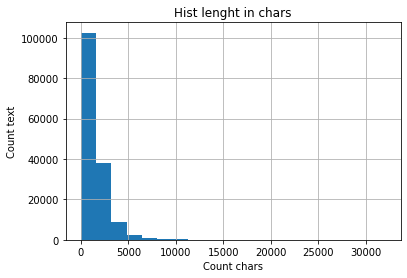

In [ ]:
import matplotlib.pyplot as plt

df['lenght_in_char'] = df['text'].apply(lambda x: len(x))
df['lenght_in_word'] = df['text'].apply(lambda x: len(x.split(' ')))
df['lenght_in_char'].hist(bins=20)
plt.title('Hist lenght in chars')
plt.xlabel('Count chars')
plt.ylabel('Count text')
plt.show()

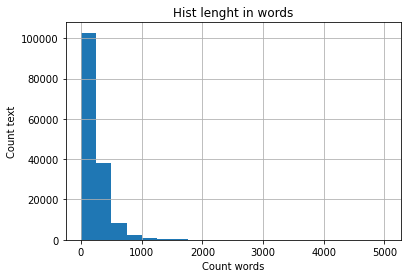

In [ ]:
df['lenght_in_word'].hist(bins=20)
plt.title('Hist lenght in words')
plt.xlabel('Count words')
plt.ylabel('Count text')
plt.show()

## Найдите 10 самых частых: слов, слов без стоп-слов, лемм, существительных

### Слова

In [ ]:
from string import punctuation
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from collections import Counter

vocabul = [token for tweet in df['text'] for token in word_tokenize(tweet.lower()) if token not in punctuation]
print(len(vocabul))
freq_dict = Counter(vocabul)
freq_dict.most_common(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


36766261


[('в', 1322516),
 ('и', 1054485),
 ('не', 851742),
 ('на', 704396),
 ('что', 621783),
 ('я', 573896),
 ('с', 454545),
 ('по', 365188),
 ('мне', 320695),
 ('банка', 263958)]

### Слова без стоп-слов

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

noise = stopwords.words('russian') + list(punctuation) + ['``','\'\'', '...']
vocabul = [token.lower() for tweet in df['text'] for token in word_tokenize(tweet.lower()) if token not in noise]
print(len(vocabul))
freq_dict = Counter(vocabul)
freq_dict.most_common(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


23480560


[('банка', 263958),
 ('банк', 196303),
 ('это', 183054),
 ('деньги', 130061),
 ('карту', 104947),
 ('карты', 100877),
 ('кредит', 80281),
 ('день', 75996),
 ('заявление', 69524),
 ('отделение', 66468)]

### Лемма

In [ ]:
%%capture
!pip install pymorphy2

In [ ]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

corpus_lem = []
for token in tqdm(vocabul):
    corpus_lem.append(morph.parse(token)[0].normal_form)
freq_dict = Counter(corpus_lem)
freq_dict.most_common(10)

100%|██████████| 23480560/23480560 [1:11:18<00:00, 5488.01it/s]


[('банк', 624274),
 ('карта', 331816),
 ('это', 199740),
 ('деньга', 178337),
 ('день', 172634),
 ('мой', 167035),
 ('кредит', 154863),
 ('который', 148990),
 ('отделение', 143616),
 ('счёт', 140509)]

### Существительные

In [ ]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

corpus_lem_noun = []
for token in tqdm(corpus_lem):
    p = morph.parse(token)[0]
    if 'NOUN' in p.tag:
        corpus_lem_noun.append(token)
freq_dict = Counter(corpus_lem_noun)
freq_dict.most_common(10)

100%|██████████| 23480560/23480560 [1:09:36<00:00, 5622.24it/s]


[('банк', 624274),
 ('карта', 331816),
 ('деньга', 178337),
 ('день', 172634),
 ('кредит', 154863),
 ('отделение', 143616),
 ('счёт', 140509),
 ('сотрудник', 133662),
 ('клиент', 132908),
 ('сумма', 110914)]

# Постройте кривые Ципфа и Хипса

## Закон Ципфа

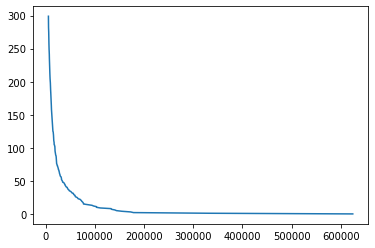

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

## Закон Хипса

In [ ]:
from tqdm import tqdm

cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for row in df['text']:
    tokens = word_tokenize(row)
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(cnt.values()))

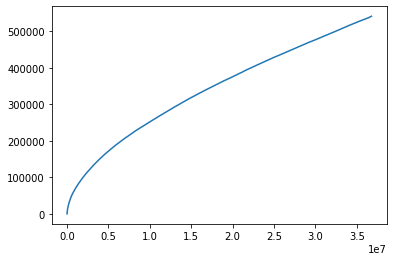

In [ ]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

# Ответьте на следующие вопросы:

## какое слово встречается чаще, "сотрудник" или "клиент"?

In [ ]:
employee = freq_dict['сотрудник']
client = freq_dict['клиент']
if employee > client:
    print(f'"сотрудник" чаще {employee} > {client}')
elif employee < client:
    print(f'"клиент" чаще {employee} < {client}')
else:
    print(f'"сотрудник" равен "клиент" {employee} = {client}')

"сотрудник" чаще 133662 > 132908


## сколько раз встречается слова "мошенничество" и "доверие"?

In [ ]:
print('"мошенничество" встречается', freq_dict['мошенничество'], 'раз')
print('"доверие" встречается', freq_dict['доверие'], 'раз')

"мошенничество" встречается 3228 раз
"доверие" встречается 2098 раз


# В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру tf-idf, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

Здесь ищется скорее наиболее среднее сообщение для оцененных в 1 и 5

In [ ]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html?highlight=scipy%20sparse%20csr%20csr_matrix#scipy.sparse.csr_matrix

In [ ]:
%%capture
!pip install pymorphy2

## 1

In [ ]:
data_1 = df[df['rating_grade'].isin([1])]

In [ ]:
from string import punctuation
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import pymorphy2

morph = pymorphy2.MorphAnalyzer()
noise = stopwords.words('russian') + list(punctuation) + ['``','\'\'', '...']
tweets = []
for tweet in data_1['text']:
    s = ''
    for token in word_tokenize(tweet.lower()):
        if token not in noise:
            s += morph.parse(token)[0].normal_form + ' '
    tweets.append(s)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tweets[0]

"открыть вклад счёт usd плюс этот зарплатный карта рубль сам себя сегодня прийти указанный отделение цель пополнить долларовый счёт 700 usd дать операционист паспорт зарплатный карта т.к окошко написать приготовить карта подтверждение операция что-то подобный прошлый потребовать сказать нужно положить деньга долларовый счёт операционист всё взять что-то делала-крутила-вертеть вставить карта терминал сказать ввести пин ввести пин получить ответ чек написать доллар внести .... счёт карта рубль вопрос банк №1 риторический понимать кто нужно сознательно проводить такой операция угол маленький квартал курс приём валюта выше рубль действительно хотеть совершить такой хитрый операция выгодный сделать 100 шаг заработать около 700 рубль просто внести рубль счёт карта банкомат далее долгий около два час выяснение отношение операционист видимо начальник попытка отменить первый транзакция т.д т.п. сойтись компенсировать курсовой разница зачисление доллар рублёвый карта 54,6 руб/доллар слово операц

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 2))
tfidf_tweets = tfidf.fit_transform(tweets)

In [ ]:
# https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
import numpy as np

ind = np.argsort(tfidf_tweets.mean(axis=0).tolist()[0])
tfidf.get_feature_names_out()[ind[-30:]]

array(['кредитный', 'получить', 'время', 'ответ', 'звонить', 'договор',
       'вопрос', 'то', 'офис', 'свой', 'год', 'платёж', 'сбербанк',
       'вклад', 'сумма', 'банкомат', 'клиент', 'который', 'сказать',
       'заявление', 'сотрудник', 'мой', 'счёт', 'это', 'день',
       'отделение', 'кредит', 'деньга', 'карта', 'банк'], dtype=object)

## 5

In [ ]:
data_5 = df[df['rating_grade'].isin([5])]

In [ ]:
from string import punctuation
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import pymorphy2

morph = pymorphy2.MorphAnalyzer()
noise = stopwords.words('russian') + list(punctuation) + ['``','\'\'', '...']
tweets = []
for tweet in data_5['text']:
    s = ''
    for token in word_tokenize(tweet.lower()):
        if token not in noise:
            s += morph.parse(token)[0].normal_form + ' '
    tweets.append(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tweets[0]

'досрочно закрывать вклад отпуск жена заказывать заранее забыть заказать сотрудник банк спб ленсовет 89 наталья отказать хотя сумма значительный работать быстро профессионально лишний жаль прикрыть приём вклад офис озерко доступность офис заметить нести деньга вклад брать кредит желать успех банк '

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 2))
tfidf_tweets = tfidf.fit_transform(tweets)

In [ ]:
import numpy as np

ind = np.argsort(tfidf_tweets.mean(axis=0).tolist()[0])
tfidf.get_feature_names_out()[ind[-30:]]

array(['быстро', 'то', 'очередь', 'работать', 'сказать', 'кредитный',
       'спасибо', 'документ', 'проблема', 'свой', 'обслуживание',
       'работа', 'время', 'вопрос', 'год', 'мой', 'который', 'счёт',
       'офис', 'деньга', 'сотрудник', 'клиент', 'день', 'это',
       'отделение', 'очень', 'кредит', 'вклад', 'карта', 'банк'],
      dtype=object)

# Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем

In [ ]:
%%capture
!pip install pymorphy2

In [ ]:
data = df

In [ ]:
from tqdm import tqdm
from string import punctuation
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import pymorphy2

morph = pymorphy2.MorphAnalyzer()
noise = stopwords.words('russian') + list(punctuation) + ['``','\'\'', '...']
tweets = []
for tweet in tqdm(data['text']):
    s = []
    for token in word_tokenize(tweet.lower()):
        if (token not in noise) & (not token.isnumeric()):
            # s.append(morph.parse(token)[0].normal_form) # Лемматизация длительная операция
            s.append(token)
    tweets.append(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 153499/153499 [10:59<00:00, 232.93it/s]


## LDA 30 тем

https://webdevblog.ru/gensim-rukovodstvo-dlya-nachinajushhih/

In [ ]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(tweets)

In [ ]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(tweet) for tweet in tweets if len(tweet) > 10]

In [ ]:
# from gensim import corpora

# # Save the Dict and Corpus
# dictionary.save('mydict.dict')  # save dict to disk
# corpora.MmCorpus.serialize('bow_corpus.mm', corpus)  # save corpus to disk

In [ ]:
# # Load them back
# dictionary = corpora.Dictionary.load('mydict.dict')
# corpus = corpora.MmCorpus('bow_corpus.mm')

In [ ]:
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py

# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 30

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    )

In [ ]:
model.show_topics(num_topics=30 , num_words=5)

[(0,
  '0.014*"банка" + 0.011*"отделение" + 0.010*"девушка" + 0.009*"это" + 0.007*"минут"'),
 (1,
  '0.031*"кредит" + 0.014*"это" + 0.014*"нам" + 0.012*"кредита" + 0.012*"банк"'),
 (2,
  '0.033*"очень" + 0.017*"банка" + 0.012*"банк" + 0.011*"быстро" + 0.010*"спасибо"'),
 (3,
  '0.054*"номер" + 0.027*"телефона" + 0.025*"телефон" + 0.021*"банка" + 0.015*"номера"'),
 (4,
  '0.034*"руб" + 0.032*"рублей" + 0.026*"сумма" + 0.023*"счет" + 0.020*"сумму"'),
 (5,
  '0.018*"банка" + 0.018*"это" + 0.013*"банк" + 0.006*"сотрудники" + 0.005*"просто"'),
 (6,
  '0.031*"заявку" + 0.017*"заявки" + 0.014*"анкету" + 0.014*"сайте" + 0.012*"решение"'),
 (7,
  '0.020*"птс" + 0.012*"абсолют" + 0.009*"ордер" + 0.006*"ячейку" + 0.006*"долл"'),
 (8,
  '0.015*"карты" + 0.011*"банка" + 0.011*"банк" + 0.010*"это" + 0.008*"картой"'),
 (9,
  '0.030*"кредит" + 0.015*"банк" + 0.014*"банка" + 0.013*"сумму" + 0.012*"кредита"'),
 (10,
  '0.021*"очереди" + 0.019*"минут" + 0.016*"очередь" + 0.013*"это" + 0.009*"кассу"'),
 (

## LDI 30 тем

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
id2word = dictionary.id2token

In [ ]:
from gensim.models import lsimodel

lsi = lsimodel.LsiModel(corpus=corpus, id2word=id2word, num_topics=30)

In [ ]:
lsi.show_topics(num_topics=30 , num_words=10)

[(0,
  '0.428*"банка" + 0.313*"банк" + 0.299*"это" + 0.186*"деньги" + 0.169*"карты" + 0.167*"«" + 0.165*"»" + 0.163*"карту" + 0.111*"заявление" + 0.111*"кредит"'),
 (1,
  '-0.659*"«" + -0.653*"»" + -0.189*"–" + 0.120*"банка" + 0.101*"деньги" + 0.099*"карту" + 0.092*"это" + 0.065*"карты" + 0.051*"банк" + 0.044*"отделение"'),
 (2,
  '-0.998*"--" + -0.023*"карты" + 0.017*"кредит" + 0.015*"банка" + 0.014*"«" + 0.014*"»" + -0.012*"карта" + -0.012*"операции" + 0.011*"это" + -0.010*"карту"'),
 (3,
  '0.513*"банка" + -0.410*"карту" + -0.383*"карты" + -0.248*"деньги" + 0.228*"банк" + 0.221*"кредит" + -0.192*"карта" + -0.124*"сбербанка" + 0.122*"кредита" + -0.111*"это"'),
 (4,
  '0.495*"банка" + 0.403*"карты" + -0.399*"это" + -0.295*"деньги" + 0.261*"карту" + -0.202*"кредит" + 0.168*"карта" + -0.117*"банк" + -0.083*"очень" + 0.078*"карте"'),
 (5,
  '0.523*"деньги" + -0.458*"это" + 0.281*"банк" + 0.172*"счет" + 0.168*"заявление" + 0.140*"рублей" + 0.129*"средств" + -0.115*"очень" + 0.107*"денег" 

# Часть 3. Классификация текстов

In [ ]:
df_classification = df[df['rating_grade'].isin([1, 5])]
df_classification.shape

(62100, 10)

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder().fit(df_classification['rating_grade'])
print(le.classes_)
y = le.transform(df_classification['rating_grade'])
X = df_classification['text']

[1. 5.]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# @title Униграмы

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(X_train) # bow -- bag of words (мешок слов)

clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [ ]:
from sklearn.metrics import classification_report

pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     11911
           1       0.92      0.94      0.93      3614

    accuracy                           0.97     15525
   macro avg       0.95      0.96      0.95     15525
weighted avg       0.97      0.97      0.97     15525



In [ ]:
# @title Биграмы

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(ngram_range=(1, 2))
bow = vec.fit_transform(X_train) # bow -- bag of words (мешок слов)

clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [ ]:
from sklearn.metrics import classification_report

pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11973
           1       0.92      0.96      0.94      3552

    accuracy                           0.97     15525
   macro avg       0.95      0.97      0.96     15525
weighted avg       0.97      0.97      0.97     15525



In [ ]:
# @title Ttf-idf + LSI

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

vocabulary = list(dictionary.id2token.values())
clf = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(1, 1), vocabulary=vocabulary)), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=30, n_iter=7, random_state=42)), 
    ('clf', LogisticRegression(random_state=42, solver='liblinear'))
])
clf.fit(X_train, y_train)


Pipeline(steps=[('vect',
                 CountVectorizer(vocabulary=['09.10.2014', '20.10.2013',
                                             'адрес', 'адресе', 'банк', 'банка',
                                             'банком', 'бесконечные', 'бояться',
                                             'буду', 'вашей', 'взятых',
                                             'владимировича', 'возбуждении',
                                             'возмещение', 'вопроса',
                                             'вопросам', 'вреда', 'всей',
                                             'вынуждена', 'вышеуказанный',
                                             'года', 'город', 'гражданин',
                                             'гражданина', 'гражданские',
                                             'данных', 'дела', 'день', 'добрый', ...])),
                ('tfidf', TfidfTransformer()),
                ('tm',
                 TruncatedSVD(n_components=30, n_iter=7, random_

In [ ]:
from sklearn.metrics import classification_report

pred = clf.predict(X_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96     12408
           1       0.78      0.93      0.84      3117

    accuracy                           0.93     15525
   macro avg       0.88      0.93      0.90     15525
weighted avg       0.94      0.93      0.93     15525



In [ ]:
# @title  LDA

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression

vocabulary = list(dictionary.id2token.values())
clf = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(1, 1), vocabulary=vocabulary)), 
    # ('tfidf', TfidfTransformer()), 
    ('tm', LatentDirichletAllocation(n_components=30, random_state=42)), 
    ('clf', LogisticRegression(random_state=42, solver='liblinear'))
])
clf.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(vocabulary=['09.10.2014', '20.10.2013',
                                             'адрес', 'адресе', 'банк', 'банка',
                                             'банком', 'бесконечные', 'бояться',
                                             'буду', 'вашей', 'взятых',
                                             'владимировича', 'возбуждении',
                                             'возмещение', 'вопроса',
                                             'вопросам', 'вреда', 'всей',
                                             'вынуждена', 'вышеуказанный',
                                             'года', 'город', 'гражданин',
                                             'гражданина', 'гражданские',
                                             'данных', 'дела', 'день', 'добрый', ...])),
                ('tm',
                 LatentDirichletAllocation(n_components=30, random_state=42)),
                ('clf',
        

In [ ]:
from sklearn.metrics import classification_report

pred = clf.predict(X_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     12372
           1       0.76      0.90      0.82      3153

    accuracy                           0.92     15525
   macro avg       0.87      0.91      0.89     15525
weighted avg       0.93      0.92      0.92     15525

